In [1]:
import os
import io
import shutil
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertForSequenceClassification

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.utils import resample

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Flatten, SimpleRNN, Dropout, Bidirectional, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm, trange

warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS'] = 'ignore'
os.environ['TRANSFORMERS_CACHE'] = '/mnt/raid1/eliza/TEXT_MINING/trans_cache'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TOKENIZERS_PARALLELISM"] = "false"
cache = '/mnt/raid1/eliza/TEXT_MINING/trans_cache'
model_name = 'dmis-lab/biobert-base-cased-v1.2'  # dmis-lab/biobert-base-cased-v1.2 dmis-lab/biobert-v1.1
models_path = 'models/first_run/Biobert/'
os.environ['TRANSFORMERS_CACHE'] = cache
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


2025-03-17 14:55:41.384997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 14:55:41.424728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 14:55:41.424757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 14:55:41.426160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 14:55:41.433265: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_set = pd.read_csv('data/manual_curation/train.csv')
test_set = pd.read_csv('data/manual_curation/test.csv')

train_labels = train_set["LABEL"].values
validation_labels = test_set["LABEL"].values

train_sents = train_set["SENTENCE"]
validation_sents = test_set["SENTENCE"]

device = torch.device("cpu")

tokenizer_f = AutoTokenizer.from_pretrained(model_name, cache_dir= cache)

model_f = AutoModel.from_pretrained(model_name, cache_dir= cache)

In [3]:
# setting the max length for padding

In [4]:
max_len = 128

tokenized_train_f = train_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))
tokenized_val_f = validation_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))

padded_train_f = np.array([i + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_train_f.values])
padded_val_f = np.array([i + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_val_f.values])

attention_mask_train_f = np.where(padded_train_f != 0, 1, 0)
attention_mask_val_f = np.where(padded_val_f != 0, 1, 0)

input_ids_train_f = torch.tensor(padded_train_f)  
input_ids_val_f = torch.tensor(padded_val_f)  

attention_mask_train_f = torch.tensor(attention_mask_train_f)
attention_mask_val_f = torch.tensor(attention_mask_val_f)

with torch.no_grad():
    last_hidden_states_train = model_f(input_ids_train_f, attention_mask=attention_mask_train_f)
    last_hidden_states_val = model_f(input_ids_val_f, attention_mask=attention_mask_val_f)


features_train = last_hidden_states_train[0][:,0,:].numpy()
features_val= last_hidden_states_val[0][:,0,:].numpy()

train_labels_l = torch.tensor(train_labels).long()
validation_labels_l = torch.tensor(validation_labels).long()

In [5]:
# Logistic Regression

In [6]:

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}

lr_clf = LogisticRegression(random_state=42)
# Create a pipeline with scaling and logistic regression

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=20, error_score="raise")
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Evaluate the best model on the validation set
best_lr_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_lr_model, models_path + '/lr_model.pkl')

# Load the best model
best_lr_model = joblib.load( models_path + '/lr_model.pkl')

lr_pred = best_lr_model.predict(features_val)

print("Classification report on the validation set:")
print(classification_report(validation_labels_l, lr_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy (Cross-Validation): 0.7782589658878318
Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       322
           1       0.78      0.87      0.83       511

    accuracy                           0.78       833
   macro avg       0.77      0.75      0.75       833
weighted avg       0.77      0.78      0.77       833



In [7]:
# SVM

In [8]:
# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],               
    'gamma': ['scale', 'auto', 0.1, 0.01], 
    'kernel': ['rbf'],                      
    'probability': [True]                  
}

# Initialize the SVM model
svm_clf = SVC(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', n_jobs=20, verbose=1)

# Fit the model using the training data
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Train the best model on the entire training set (optional, since GridSearchCV has already done this)
best_svm_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_svm_model, models_path + '/svm_model.pkl')

# Load the best model
best_svm_model = joblib.load(models_path + '/svm_model.pkl')

# Make predictions using the best model on the validation set
svm_pred = best_svm_model.predict(features_val)

# Print the classification report for the best model
print("Classification report for the best model:")
print(classification_report(validation_labels_l, svm_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
Best Accuracy (Cross-Validation): 0.7810940174342236
Classification report for the best model:
              precision    recall  f1-score   support

           0       0.80      0.57      0.66       322
           1       0.77      0.91      0.83       511

    accuracy                           0.78       833
   macro avg       0.78      0.74      0.75       833
weighted avg       0.78      0.78      0.77       833



In [9]:
# Random Forest

In [10]:
# Define the parameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 200],               
    'max_depth': [None, 10, 20, 30],               
    'min_samples_split': [2, 5, 10],               
    'min_samples_leaf': [1, 2, 4],                 
    'max_features': ['sqrt', 'log2'],     
    'bootstrap': [True, False]                     
}

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=30, verbose=1)

# Fit the model using the training data
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Train the best model on the entire training set (optional, since GridSearchCV has already done this)
best_rf_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_rf_model, models_path + '/rf_model.pkl')

# Load the best model
best_rf_model = joblib.load(models_path + '/rf_model.pkl')

# Make predictions using the best Random Forest model on the validation set
rf_pred = best_rf_model.predict(features_val)

# Print the classification report for the best model
print("Classification report for Random Forest Classifier:")
print(classification_report(validation_labels_l, rf_pred))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy (Cross-Validation): 0.7620347888389125
Classification report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       322
           1       0.75      0.92      0.83       511

    accuracy                           0.76       833
   macro avg       0.78      0.72      0.73       833
weighted avg       0.77      0.76      0.75       833



In [11]:
# reshape features for Deep

In [12]:
train_bert_features = last_hidden_states_train.last_hidden_state
test_bert_features = last_hidden_states_val.last_hidden_state

train_bert_features_reshaped = tf.reshape(train_bert_features, (train_bert_features.shape[0], train_bert_features.shape[1], -1))
test_bert_features_reshaped = tf.reshape(test_bert_features, (test_bert_features.shape[0], test_bert_features.shape[1], -1))

train_bert_features_reshaped = tf.convert_to_tensor(train_bert_features_reshaped, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_bert_features_reshaped = tf.convert_to_tensor(test_bert_features_reshaped, dtype=tf.float32)
validation_labels = tf.convert_to_tensor(validation_labels, dtype=tf.float32)

In [13]:
# LSTM

In [14]:
from tensorflow.keras.optimizers.legacy import Adam

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(train_bert_features_reshaped.shape[1],
                                                                               train_bert_features_reshaped.shape[2]), 
                                                                               dropout=0.3, recurrent_dropout=0.3)))
    model_lstm.add(Bidirectional(LSTM(128, return_sequences=False)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(64, activation='relu'))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.compile(metrics=['accuracy'], optimizer=optimizer, loss='binary_crossentropy')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_lstm_fold_' + str(int(fold)) + '.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model_lstm.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_lstm.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_lstm.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_lstm_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_lstm_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_lstm.h5')
best_lstm_model = load_model(models_path + '/model_lstm.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_lstm_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_lstm_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 38s 614ms/step - loss: 0.6051 - accuracy: 0.6748 - val_loss: 0.5134 - val_accuracy: 0.7568
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 27s 542ms/step - loss: 0.5280 - accuracy: 0.7482 - val_loss: 0.5299 - val_accuracy: 0.7722
Epoch 3/20
49/49 [==============================] - 22s 456ms/step - loss: 0.5001 - accuracy: 0.7614 - val_loss: 0.5204 - val_accuracy: 0.7503
Epoch 4/20
49/49 [==============================] - 21s 430ms/step - loss: 0.4528 - accuracy: 0.7923 - val_loss: 0.4761 - val_accuracy: 0.7786
Epoch 5/20
49/49 [==============================] - 21s 427ms/step - loss: 0.4560 - accuracy: 0.7875 - val_loss: 0.4826 - val_accuracy: 0.7799
Epoch 6/20
49/49 [==============================] - 27s 563ms/step - loss: 0.4273 - accuracy: 0.8142 - val_loss: 0.5494 - val_accuracy: 0.7413
Epoch 7/20
49/49 [==============================] - 29s 590ms/step - loss: 0.3571 - accuracy: 0.8445 - val_loss: 0.5471 - val_accuracy: 0.7413
Fold 2:


/tmp/ipykernel_4001525/1908550099.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 42s 675ms/step - loss: 0.6407 - accuracy: 0.6449 - val_loss: 0.6010 - val_accuracy: 0.6937
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 31s 639ms/step - loss: 0.5626 - accuracy: 0.7202 - val_loss: 0.4901 - val_accuracy: 0.7889
Epoch 3/20
49/49 [==============================] - 31s 629ms/step - loss: 0.5054 - accuracy: 0.7618 - val_loss: 0.5523 - val_accuracy: 0.7413
Epoch 4/20
49/49 [==============================] - 31s 627ms/step - loss: 0.4904 - accuracy: 0.7675 - val_loss: 0.4936 - val_accuracy: 0.7709
Epoch 5/20
49/49 [==============================] - 30s 620ms/step - loss: 0.4439 - accuracy: 0.7985 - val_loss: 0.4840 - val_accuracy: 0.7748
Epoch 6/20
49/49 [==============================] - 30s 608ms/step - loss: 0.4161 - accuracy: 0.8155 - val_loss: 0.5025 - val_accuracy: 0.7645
Epoch 7/20
49/49 [==============================] - 26s 541ms/step - loss: 0.3786 - accuracy: 0.8345 - val_loss: 0.4808 - val_accuracy: 0.7876
Epoch 8/20
49/49 [==============================] - 30s 612ms/step - loss: 0.3287 - accuracy: 0.8616 - val_loss: 0.4935 - val_accuracy: 0.7748
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 43s 676ms/step - loss: 0.6876 - accuracy: 0.6011 - val_loss: 0.6664 - val_accuracy: 0.5985
Epoch 2/20
49/49 [==============================] - 32s 647ms/step - loss: 0.6186 - accuracy: 0.6590 - val_loss: 0.6246 - val_accuracy: 0.6976
Epoch 3/20
49/49 [==============================] - 32s 653ms/step - loss: 0.5334 - accuracy: 0.7486 - val_loss: 0.5625 - val_accuracy: 0.7310
Epoch 4/20
49/49 [==============================] - 32s 649ms/step - loss: 0.4895 - accuracy: 0.7846 - val_loss: 0.5267 - val_accuracy: 0.7606
Epoch 5/20
49/49 [==============================] - 31s 627ms/step - loss: 0.4592 - accuracy: 0.7978 - val_loss: 0.5905 - val_accuracy: 0.7284
Epoch 6/20
49/49 [==============================] - 31s 627ms/step - loss: 0.4184 - accuracy: 0.8178 - val_loss: 0.5461 - val_accuracy: 0.7542
Epoch 7/20
49/49 [==============================] - 31s 626ms/step - loss: 0.3756 - accuracy: 0.8361 - val_loss: 0.5518 - val_accuracy: 0.7580
Fold 4:
Ep

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 37s 558ms/step - loss: 0.6818 - accuracy: 0.5922 - val_loss: 0.6361 - val_accuracy: 0.6327
Epoch 2/20
49/49 [==============================] - 30s 607ms/step - loss: 0.5788 - accuracy: 0.7142 - val_loss: 0.5774 - val_accuracy: 0.7113
Epoch 3/20
49/49 [==============================] - 30s 619ms/step - loss: 0.5014 - accuracy: 0.7712 - val_loss: 0.5291 - val_accuracy: 0.7410
Epoch 4/20
49/49 [==============================] - 30s 616ms/step - loss: 0.4675 - accuracy: 0.7834 - val_loss: 0.5266 - val_accuracy: 0.7384
Epoch 5/20
49/49 [==============================] - 30s 615ms/step - loss: 0.4324 - accuracy: 0.8030 - val_loss: 0.5288 - val_accuracy: 0.7345
Epoch 6/20
49/49 [==============================] - 30s 618ms/step - loss: 0.3896 - accuracy: 0.8362 - val_loss: 0.5473 - val_accuracy: 0.7513
Epoch 7/20
49/49 [==============================] - 30s 620ms/step - loss: 0.3382 - accuracy: 0.8590 - val_loss: 0.5653 - val_accuracy: 0.7487
Fold 5:
Ep

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 43s 669ms/step - loss: 0.6762 - accuracy: 0.6077 - val_loss: 0.6459 - val_accuracy: 0.6031
Epoch 2/20
49/49 [==============================] - 31s 638ms/step - loss: 0.5984 - accuracy: 0.6794 - val_loss: 0.5407 - val_accuracy: 0.7436
Epoch 3/20
49/49 [==============================] - 31s 624ms/step - loss: 0.5360 - accuracy: 0.7409 - val_loss: 0.5630 - val_accuracy: 0.7423
Epoch 4/20
49/49 [==============================] - 26s 524ms/step - loss: 0.4787 - accuracy: 0.7789 - val_loss: 0.5303 - val_accuracy: 0.7616
Epoch 5/20
49/49 [==============================] - 29s 602ms/step - loss: 0.4409 - accuracy: 0.8014 - val_loss: 0.5349 - val_accuracy: 0.7513
Epoch 6/20
49/49 [==============================] - 30s 616ms/step - loss: 0.4070 - accuracy: 0.8233 - val_loss: 0.5658 - val_accuracy: 0.7410
Epoch 7/20
49/49 [==============================] - 30s 616ms/step - loss: 0.3610 - accuracy: 0.8458 - val_loss: 0.5915 - val_accuracy: 0.7281
Best Model

In [15]:
best_lstm_model = load_model(models_path + '/model_lstm.h5')
lstm_pred = np.round(best_lstm_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, lstm_pred))

27/27 [==============================] - 5s 133ms/step
              precision    recall  f1-score   support

         0.0       0.85      0.53      0.65       322
         1.0       0.76      0.94      0.84       511

    accuracy                           0.78       833
   macro avg       0.80      0.73      0.74       833
weighted avg       0.79      0.78      0.77       833



In [16]:
# CNN

In [17]:

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Create the CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', 
                         input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2])))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.3))
    cnn_model.add(Conv1D(256, kernel_size=3, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5)) 
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_cnn_fold_' + str(int(fold)) + '.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = cnn_model.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_cnn.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_cnn.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_cnn_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_cnn_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_cnn.h5')
best_cnn_model = load_model(models_path + '/model_cnn.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_cnn_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_cnn_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 3s 35ms/step - loss: 0.6906 - accuracy: 0.6088 - val_loss: 0.6086 - val_accuracy: 0.7027
Epoch 2/20
 7/49 [===>..........................] - ETA: 0s - loss: 0.5371 - accuracy: 0.7567

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 22ms/step - loss: 0.5583 - accuracy: 0.7366 - val_loss: 0.5652 - val_accuracy: 0.7580
Epoch 3/20
49/49 [==============================] - 1s 24ms/step - loss: 0.5134 - accuracy: 0.7608 - val_loss: 0.5062 - val_accuracy: 0.7696
Epoch 4/20
49/49 [==============================] - 1s 25ms/step - loss: 0.4950 - accuracy: 0.7807 - val_loss: 0.4934 - val_accuracy: 0.7864
Epoch 5/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4720 - accuracy: 0.7878 - val_loss: 0.4900 - val_accuracy: 0.8005
Epoch 6/20
49/49 [==============================] - 1s 25ms/step - loss: 0.4145 - accuracy: 0.8104 - val_loss: 0.4518 - val_accuracy: 0.8082
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.3951 - accuracy: 0.8342 - val_loss: 0.4297 - val_accuracy: 0.8147
Epoch 8/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3440 - accuracy: 0.8542 - val_loss: 0.4271 - val_accuracy: 0.8018
Epoch 9/20
49/49 [======

/tmp/ipykernel_4001525/3587167567.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 3s 39ms/step - loss: 0.6841 - accuracy: 0.6146 - val_loss: 0.6338 - val_accuracy: 0.7259
Epoch 2/20
 6/49 [==>...........................] - ETA: 1s - loss: 0.5857 - accuracy: 0.6953

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 27ms/step - loss: 0.5723 - accuracy: 0.7015 - val_loss: 0.5364 - val_accuracy: 0.7580
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5250 - accuracy: 0.7437 - val_loss: 0.5245 - val_accuracy: 0.7722
Epoch 4/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4978 - accuracy: 0.7550 - val_loss: 0.4784 - val_accuracy: 0.7722
Epoch 5/20
49/49 [==============================] - 1s 25ms/step - loss: 0.4652 - accuracy: 0.7769 - val_loss: 0.4676 - val_accuracy: 0.7851
Epoch 6/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4458 - accuracy: 0.7836 - val_loss: 0.4321 - val_accuracy: 0.7967
Epoch 7/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4179 - accuracy: 0.7985 - val_loss: 0.4208 - val_accuracy: 0.8069
Epoch 8/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3661 - accuracy: 0.8162 - val_loss: 0.4233 - val_accuracy: 0.8172
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 27ms/step - loss: 0.6575 - accuracy: 0.6159 - val_loss: 0.6365 - val_accuracy: 0.6010
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.6227 - accuracy: 0.6211 - val_loss: 0.5870 - val_accuracy: 0.7117
Epoch 4/20
49/49 [==============================] - 1s 27ms/step - loss: 0.5913 - accuracy: 0.6816 - val_loss: 0.5748 - val_accuracy: 0.7619
Epoch 5/20
49/49 [==============================] - 1s 28ms/step - loss: 0.5812 - accuracy: 0.6803 - val_loss: 0.5458 - val_accuracy: 0.7387
Epoch 6/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5653 - accuracy: 0.6906 - val_loss: 0.5599 - val_accuracy: 0.7362
Epoch 7/20
49/49 [==============================] - 1s 25ms/step - loss: 0.5292 - accuracy: 0.7102 - val_loss: 0.5468 - val_accuracy: 0.7645
Epoch 8/20
49/49 [==============================] - 1s 25ms/step - loss: 0.5216 - accuracy: 0.6941 - val_loss: 0.5322 - val_accuracy: 0.7606
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 27ms/step - loss: 0.5789 - accuracy: 0.6897 - val_loss: 0.6101 - val_accuracy: 0.6907
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.5723 - accuracy: 0.7316 - val_loss: 0.5929 - val_accuracy: 0.7281
Epoch 4/20
49/49 [==============================] - 1s 25ms/step - loss: 0.5437 - accuracy: 0.7547 - val_loss: 0.5601 - val_accuracy: 0.7603
Epoch 5/20
49/49 [==============================] - 1s 25ms/step - loss: 0.5017 - accuracy: 0.7856 - val_loss: 0.5434 - val_accuracy: 0.7345
Epoch 6/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4522 - accuracy: 0.7947 - val_loss: 0.4965 - val_accuracy: 0.7513
Epoch 7/20
49/49 [==============================] - 1s 29ms/step - loss: 0.4137 - accuracy: 0.8165 - val_loss: 0.4669 - val_accuracy: 0.7745
Epoch 8/20
49/49 [==============================] - 1s 28ms/step - loss: 0.3826 - accuracy: 0.8342 - val_loss: 0.4562 - val_accuracy: 0.7809
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 27ms/step - loss: 0.6471 - accuracy: 0.6083 - val_loss: 0.5839 - val_accuracy: 0.6327
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.5812 - accuracy: 0.6701 - val_loss: 0.5583 - val_accuracy: 0.7693
Epoch 4/20
49/49 [==============================] - 1s 28ms/step - loss: 0.5583 - accuracy: 0.6910 - val_loss: 0.5549 - val_accuracy: 0.7822
Epoch 5/20
49/49 [==============================] - 1s 27ms/step - loss: 0.5049 - accuracy: 0.7464 - val_loss: 0.4808 - val_accuracy: 0.8015
Epoch 6/20
49/49 [==============================] - 1s 28ms/step - loss: 0.4702 - accuracy: 0.7641 - val_loss: 0.4667 - val_accuracy: 0.7912
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4401 - accuracy: 0.7757 - val_loss: 0.4466 - val_accuracy: 0.8080
Epoch 8/20
49/49 [==============================] - 1s 28ms/step - loss: 0.4219 - accuracy: 0.7866 - val_loss: 0.4363 - val_accuracy: 0.8106
Epoch 9/20
49/49 [======

In [18]:
best_cnn_model = load_model(models_path + '/model_cnn.h5')
cnn_pred = np.round(best_cnn_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, cnn_pred))

27/27 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       322
         1.0       0.84      0.88      0.86       511

    accuracy                           0.82       833
   macro avg       0.82      0.80      0.81       833
weighted avg       0.82      0.82      0.82       833



In [19]:
# GRU

In [20]:
num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Create the GRU model
    gru_model = Sequential()
    gru_model.add(Bidirectional(GRU(256, input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2]), 
                                    return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    gru_model.add(Bidirectional(GRU(128, return_sequences=False)))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    gru_model.compile(metrics=['accuracy'], optimizer=optimizer, loss='binary_crossentropy')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_gru_fold_' + str(int(fold)) + '.h5', monitor='val_accuracy', save_best_only=True)

    # Train the model
    history = gru_model.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_gru.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_gru.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_gru_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_gru_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_gru.h5')
best_gru_model = load_model(models_path + '/model_gru.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_gru_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_gru_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 40s 608ms/step - loss: 0.6221 - accuracy: 0.6607 - val_loss: 0.5385 - val_accuracy: 0.7477
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 23s 458ms/step - loss: 0.5332 - accuracy: 0.7457 - val_loss: 0.5251 - val_accuracy: 0.7375
Epoch 3/20
49/49 [==============================] - 27s 553ms/step - loss: 0.5027 - accuracy: 0.7582 - val_loss: 0.5108 - val_accuracy: 0.7568
Epoch 4/20
49/49 [==============================] - 28s 565ms/step - loss: 0.4649 - accuracy: 0.7766 - val_loss: 0.4835 - val_accuracy: 0.7671
Epoch 5/20
49/49 [==============================] - 28s 571ms/step - loss: 0.4254 - accuracy: 0.7968 - val_loss: 0.4765 - val_accuracy: 0.7722
Epoch 6/20
49/49 [==============================] - 28s 573ms/step - loss: 0.3873 - accuracy: 0.8252 - val_loss: 0.4744 - val_accuracy: 0.7799
Epoch 7/20
49/49 [==============================] - 28s 576ms/step - loss: 0.3422 - accuracy: 0.8493 - val_loss: 0.5721 - val_accuracy: 0.7851
Epoch 8/20
49/49 [==============================] - 28s 567ms/step - loss: 0.2988 - accuracy: 0.8645 - val_loss: 0.5228 - val_accuracy: 0.7812
Epoch 9/20

/tmp/ipykernel_4001525/2979893419.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 38s 610ms/step - loss: 0.6714 - accuracy: 0.6178 - val_loss: 0.5517 - val_accuracy: 0.7297
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 28s 574ms/step - loss: 0.5432 - accuracy: 0.7376 - val_loss: 0.5159 - val_accuracy: 0.7516
Epoch 3/20
49/49 [==============================] - 28s 571ms/step - loss: 0.4855 - accuracy: 0.7730 - val_loss: 0.5257 - val_accuracy: 0.7696
Epoch 4/20
49/49 [==============================] - 27s 548ms/step - loss: 0.4477 - accuracy: 0.7997 - val_loss: 0.4820 - val_accuracy: 0.7748
Epoch 5/20
49/49 [==============================] - 23s 478ms/step - loss: 0.3958 - accuracy: 0.8226 - val_loss: 0.4962 - val_accuracy: 0.7954
Epoch 6/20
49/49 [==============================] - 24s 480ms/step - loss: 0.3463 - accuracy: 0.8503 - val_loss: 0.4936 - val_accuracy: 0.8005
Epoch 7/20
49/49 [==============================] - 23s 477ms/step - loss: 0.2854 - accuracy: 0.8835 - val_loss: 0.4823 - val_accuracy: 0.8134
Fold 3:
Epoch 1/20
49/49 [==============================] - 32s 508ms/step - loss: 0.6804 - accuracy: 0.6288 - val_loss: 0.5972 - val_accuracy: 0.6950
Ep

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 22s 448ms/step - loss: 0.5576 - accuracy: 0.7357 - val_loss: 0.5257 - val_accuracy: 0.7477
Epoch 3/20
49/49 [==============================] - 26s 528ms/step - loss: 0.5129 - accuracy: 0.7618 - val_loss: 0.5956 - val_accuracy: 0.7143
Epoch 4/20
49/49 [==============================] - 27s 553ms/step - loss: 0.4547 - accuracy: 0.7910 - val_loss: 0.5104 - val_accuracy: 0.7529
Epoch 5/20
49/49 [==============================] - 27s 548ms/step - loss: 0.4178 - accuracy: 0.8117 - val_loss: 0.5735 - val_accuracy: 0.7593
Epoch 6/20
49/49 [==============================] - 27s 552ms/step - loss: 0.3710 - accuracy: 0.8345 - val_loss: 0.4898 - val_accuracy: 0.7645
Epoch 7/20
49/49 [==============================] - 27s 559ms/step - loss: 0.3027 - accuracy: 0.8664 - val_loss: 0.5814 - val_accuracy: 0.7812
Epoch 8/20
49/49 [==============================] - 27s 554ms/step - loss: 0.2370 - accuracy: 0.9057 - val_loss: 0.5301 - val_accuracy: 0.7812
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 25s 505ms/step - loss: 0.5222 - accuracy: 0.7567 - val_loss: 0.5112 - val_accuracy: 0.7629
Epoch 3/20
49/49 [==============================] - 28s 572ms/step - loss: 0.4729 - accuracy: 0.7821 - val_loss: 0.4832 - val_accuracy: 0.7784
Epoch 4/20
49/49 [==============================] - 28s 564ms/step - loss: 0.4195 - accuracy: 0.8227 - val_loss: 0.4622 - val_accuracy: 0.7990
Epoch 5/20
49/49 [==============================] - 28s 562ms/step - loss: 0.3588 - accuracy: 0.8468 - val_loss: 0.4727 - val_accuracy: 0.7899
Epoch 6/20
49/49 [==============================] - 28s 577ms/step - loss: 0.3095 - accuracy: 0.8748 - val_loss: 0.5225 - val_accuracy: 0.7436
Epoch 7/20
49/49 [==============================] - 29s 587ms/step - loss: 0.2553 - accuracy: 0.8931 - val_loss: 0.5153 - val_accuracy: 0.7784
Fold 5:
Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.5877

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 38s 618ms/step - loss: 0.7007 - accuracy: 0.5877 - val_loss: 0.5912 - val_accuracy: 0.6946
Epoch 2/20
49/49 [==============================] - 26s 523ms/step - loss: 0.5754 - accuracy: 0.7242 - val_loss: 0.5174 - val_accuracy: 0.7668
Epoch 3/20
49/49 [==============================] - 26s 529ms/step - loss: 0.5217 - accuracy: 0.7631 - val_loss: 0.4812 - val_accuracy: 0.7938
Epoch 4/20
49/49 [==============================] - 26s 534ms/step - loss: 0.4713 - accuracy: 0.7866 - val_loss: 0.4535 - val_accuracy: 0.7964
Epoch 5/20
49/49 [==============================] - 27s 553ms/step - loss: 0.4309 - accuracy: 0.8095 - val_loss: 0.4507 - val_accuracy: 0.7990
Epoch 6/20
49/49 [==============================] - 27s 557ms/step - loss: 0.3839 - accuracy: 0.8297 - val_loss: 0.4661 - val_accuracy: 0.8067
Epoch 7/20
49/49 [==============================] - 27s 551ms/step - loss: 0.3502 - accuracy: 0.8478 - val_loss: 0.4428 - val_accuracy: 0.8015
Epoch 8/20

In [21]:
best_gru_model = load_model(models_path + '/model_gru.h5')
gru_probs = best_gru_model.predict(test_bert_features_reshaped)
gru_pred = np.round(best_gru_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, gru_pred))

27/27 [==============================] - 3s 96ms/step
              precision    recall  f1-score   support

         0.0       0.85      0.63      0.72       322
         1.0       0.80      0.93      0.86       511

    accuracy                           0.81       833
   macro avg       0.82      0.78      0.79       833
weighted avg       0.82      0.81      0.81       833



In [22]:
# CNN-LSTM

In [23]:

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Define the CNN-LSTM model
    model_lc = Sequential()
    model_lc.add(Conv1D(filters=256, kernel_size=3, activation='relu',
                        input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2])))
    model_lc.add(MaxPooling1D(pool_size=2))
    model_lc.add(Dropout(0.3))
    model_lc.add(LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model_lc.add(LSTM(units=64, return_sequences=False, dropout=0.3))
    model_lc.add(Dense(units=64, activation='relu'))
    model_lc.add(Dropout(0.4))
    model_lc.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model_lc.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_cnn_lstm_fold_' + str(fold) + '.h5', monitor='val_accuracy', save_best_only=True)

    # Train the model
    history = model_lc.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3), model_checkpoint])

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_cnn_lstm.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

losses_df.to_csv(models_path + '/losses_cnn_lstm.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_cnn_lstm_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_cnn_lstm_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_cnn_lstm.h5')
best_lc_model = load_model(models_path + '/model_cnn_lstm.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_lc_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_lc_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 12s 155ms/step - loss: 0.5874 - accuracy: 0.6993 - val_loss: 0.5715 - val_accuracy: 0.7259
Epoch 2/20
 1/49 [..............................] - ETA: 5s - loss: 0.7124 - accuracy: 0.6094

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 110ms/step - loss: 0.5323 - accuracy: 0.7469 - val_loss: 0.5054 - val_accuracy: 0.7748
Epoch 3/20
49/49 [==============================] - 6s 118ms/step - loss: 0.5288 - accuracy: 0.7473 - val_loss: 0.5448 - val_accuracy: 0.7362
Epoch 4/20
49/49 [==============================] - 7s 136ms/step - loss: 0.4940 - accuracy: 0.7682 - val_loss: 0.5039 - val_accuracy: 0.7683
Epoch 5/20
49/49 [==============================] - 7s 134ms/step - loss: 0.4836 - accuracy: 0.7762 - val_loss: 0.4827 - val_accuracy: 0.7812
Epoch 6/20
49/49 [==============================] - 6s 130ms/step - loss: 0.4562 - accuracy: 0.7865 - val_loss: 0.5073 - val_accuracy: 0.7825
Epoch 7/20
49/49 [==============================] - 6s 129ms/step - loss: 0.4088 - accuracy: 0.8149 - val_loss: 0.4916 - val_accuracy: 0.7632
Epoch 8/20
49/49 [==============================] - 7s 135ms/step - loss: 0.3978 - accuracy: 0.8203 - val_loss: 0.4888 - val_accuracy: 0.7838
Fold 2:


/tmp/ipykernel_4001525/3257419321.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 14s 154ms/step - loss: 0.6402 - accuracy: 0.6384 - val_loss: 0.6001 - val_accuracy: 0.7233
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 7s 137ms/step - loss: 0.5575 - accuracy: 0.7408 - val_loss: 0.5653 - val_accuracy: 0.7272
Epoch 3/20
49/49 [==============================] - 7s 140ms/step - loss: 0.5412 - accuracy: 0.7531 - val_loss: 0.5278 - val_accuracy: 0.7490
Epoch 4/20
49/49 [==============================] - 6s 130ms/step - loss: 0.5080 - accuracy: 0.7724 - val_loss: 0.5601 - val_accuracy: 0.7490
Epoch 5/20
49/49 [==============================] - 7s 134ms/step - loss: 0.5054 - accuracy: 0.7717 - val_loss: 0.5221 - val_accuracy: 0.7465
Epoch 6/20
49/49 [==============================] - 7s 136ms/step - loss: 0.4838 - accuracy: 0.7843 - val_loss: 0.5440 - val_accuracy: 0.7349
Epoch 7/20
49/49 [==============================] - 6s 131ms/step - loss: 0.4515 - accuracy: 0.8052 - val_loss: 0.5227 - val_accuracy: 0.7465
Epoch 8/20
49/49 [==============================] - 7s 137ms/step - loss: 0.4388 - accuracy: 0.8081 - val_loss: 0.5395 - val_accuracy: 0.7426
Fold 3:
Epoch 1/2

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 7s 137ms/step - loss: 0.6276 - accuracy: 0.6555 - val_loss: 0.5945 - val_accuracy: 0.6937
Epoch 3/20
49/49 [==============================] - 7s 140ms/step - loss: 0.5695 - accuracy: 0.7270 - val_loss: 0.5726 - val_accuracy: 0.7246
Epoch 4/20
49/49 [==============================] - 7s 139ms/step - loss: 0.5215 - accuracy: 0.7605 - val_loss: 0.5398 - val_accuracy: 0.7349
Epoch 5/20
49/49 [==============================] - 6s 130ms/step - loss: 0.4983 - accuracy: 0.7798 - val_loss: 0.5398 - val_accuracy: 0.7297
Epoch 6/20
49/49 [==============================] - 7s 140ms/step - loss: 0.5042 - accuracy: 0.7733 - val_loss: 0.5382 - val_accuracy: 0.7477
Epoch 7/20
49/49 [==============================] - 7s 138ms/step - loss: 0.4675 - accuracy: 0.7904 - val_loss: 0.5574 - val_accuracy: 0.7169
Epoch 8/20
49/49 [==============================] - 6s 130ms/step - loss: 0.4673 - accuracy: 0.7910 - val_loss: 0.5370 - val_accuracy: 0.7452
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 7s 138ms/step - loss: 0.5691 - accuracy: 0.7177 - val_loss: 0.5613 - val_accuracy: 0.7345
Epoch 3/20
49/49 [==============================] - 7s 139ms/step - loss: 0.5394 - accuracy: 0.7564 - val_loss: 0.5369 - val_accuracy: 0.7384
Epoch 4/20
49/49 [==============================] - 6s 114ms/step - loss: 0.5172 - accuracy: 0.7673 - val_loss: 0.6275 - val_accuracy: 0.7036
Epoch 5/20
49/49 [==============================] - 6s 113ms/step - loss: 0.5084 - accuracy: 0.7753 - val_loss: 0.5165 - val_accuracy: 0.7577
Epoch 6/20
49/49 [==============================] - 7s 136ms/step - loss: 0.4847 - accuracy: 0.7844 - val_loss: 0.5534 - val_accuracy: 0.7371
Epoch 7/20
49/49 [==============================] - 7s 138ms/step - loss: 0.4588 - accuracy: 0.7943 - val_loss: 0.5040 - val_accuracy: 0.7796
Epoch 8/20
49/49 [==============================] - 7s 134ms/step - loss: 0.4491 - accuracy: 0.7979 - val_loss: 0.5371 - val_accuracy: 0.7642
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 7s 141ms/step - loss: 0.5659 - accuracy: 0.7374 - val_loss: 0.5427 - val_accuracy: 0.7320
Epoch 3/20
49/49 [==============================] - 7s 139ms/step - loss: 0.5328 - accuracy: 0.7538 - val_loss: 0.5258 - val_accuracy: 0.7500
Epoch 4/20
49/49 [==============================] - 7s 134ms/step - loss: 0.5113 - accuracy: 0.7747 - val_loss: 0.5302 - val_accuracy: 0.7577
Epoch 5/20
49/49 [==============================] - 7s 138ms/step - loss: 0.5078 - accuracy: 0.7634 - val_loss: 0.5001 - val_accuracy: 0.7668
Epoch 6/20
49/49 [==============================] - 7s 138ms/step - loss: 0.4711 - accuracy: 0.7811 - val_loss: 0.5274 - val_accuracy: 0.7513
Epoch 7/20
49/49 [==============================] - 7s 144ms/step - loss: 0.4731 - accuracy: 0.7808 - val_loss: 0.5444 - val_accuracy: 0.7693
Epoch 8/20
49/49 [==============================] - 7s 132ms/step - loss: 0.4505 - accuracy: 0.7879 - val_loss: 0.5077 - val_accuracy: 0.7719
Best Model Summar

In [24]:
best_lc_model = load_model(models_path + '/model_cnn_lstm.h5')
lc_probs = best_lc_model.predict(test_bert_features_reshaped)
lc_pred = np.round(best_lc_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, lc_pred))


27/27 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.65      0.70       322
         1.0       0.80      0.87      0.83       511

    accuracy                           0.78       833
   macro avg       0.78      0.76      0.76       833
weighted avg       0.78      0.78      0.78       833



In [25]:
lr_probs = best_lr_model.predict_proba(features_val)
svm_probs = best_svm_model.predict_proba(features_val)
rf_probs = best_rf_model.predict_proba(features_val)
cnn_probs = best_cnn_model.predict(test_bert_features_reshaped)
lstm_probs = best_lstm_model.predict(test_bert_features_reshaped)
gru_probs = best_gru_model.predict(test_bert_features_reshaped)
lc_probs = best_lc_model.predict(test_bert_features_reshaped)

27/27 [==============================] - 1s 27ms/step


In [26]:
# ROC curves

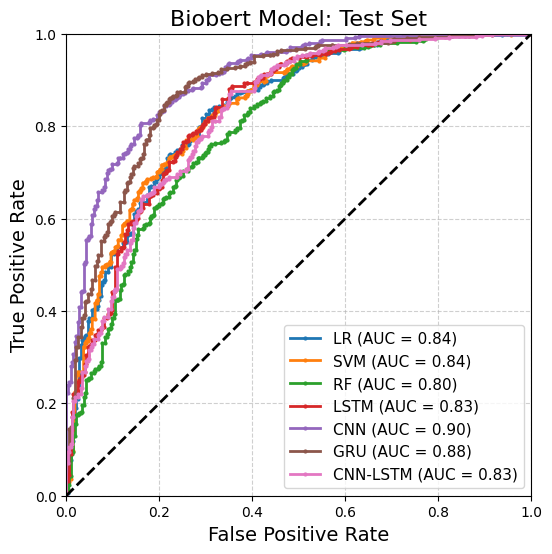

In [27]:
fpr, tpr, _ = roc_curve(validation_labels, lr_probs[:,1])
fpr2, tpr2, _ = roc_curve(validation_labels, svm_probs[:,1])
fpr3, tpr3, _ = roc_curve(validation_labels, rf_probs[:,1])
fpr4, tpr4, _ = roc_curve(validation_labels, lstm_probs)
fpr5, tpr5, _ = roc_curve(validation_labels, cnn_probs)
fpr6, tpr6, _ = roc_curve(validation_labels, gru_probs)
fpr7, tpr7, _ = roc_curve(validation_labels, lc_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)

fprs = [fpr, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
tprs = [tpr, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
roc_aucs = [roc_auc1, roc_auc2, roc_auc3, roc_auc4, roc_auc5, roc_auc6, roc_auc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))  

for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, labels):
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc), marker='.', markersize=4)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Biobert Model: Test Set', fontsize=16)

plt.legend(loc='lower right', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
#AUPRC curves

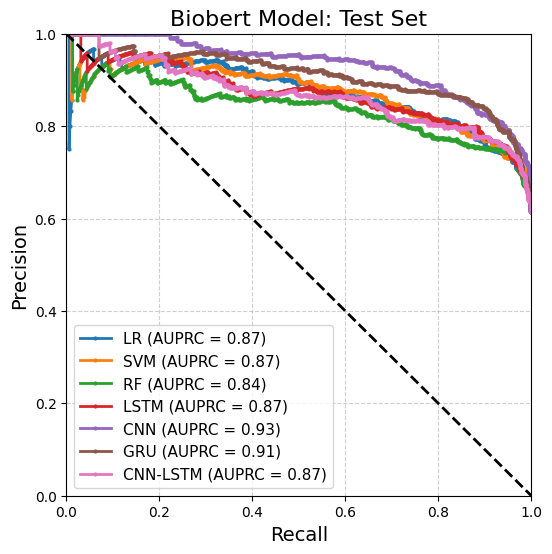

In [29]:
# Compute Precision-Recall curve for each model
precision1, recall1, _ = precision_recall_curve(validation_labels, lr_probs[:, 1])
precision2, recall2, _ = precision_recall_curve(validation_labels, svm_probs[:, 1])
precision3, recall3, _ = precision_recall_curve(validation_labels, rf_probs[:, 1])
precision4, recall4, _ = precision_recall_curve(validation_labels, lstm_probs)
precision5, recall5, _ = precision_recall_curve(validation_labels, cnn_probs)
precision6, recall6, _ = precision_recall_curve(validation_labels, gru_probs)
precision7, recall7, _ = precision_recall_curve(validation_labels, lc_probs)

# Calculate AUPRC
auprc1 = auc(recall1, precision1)
auprc2 = auc(recall2, precision2)
auprc3 = auc(recall3, precision3)
auprc4 = auc(recall4, precision4)
auprc5 = auc(recall5, precision5)
auprc6 = auc(recall6, precision6)
auprc7 = auc(recall7, precision7)

precisions = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
recalls = [recall1, recall2, recall3, recall4, recall5, recall6, recall7]
auprcs = [auprc1, auprc2, auprc3, auprc4, auprc5, auprc6, auprc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))

for precision, recall, auprc, label in zip(precisions, recalls, auprcs, labels):
    plt.plot(recall, precision, lw=2, label='{} (AUPRC = {:.2f})'.format(label, auprc), marker='.', markersize=4)

plt.plot([0, 1], [1, 0], color='black', linestyle='--', lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Biobert Model: Test Set', fontsize=16)

plt.legend(loc='lower left', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/prc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
# data table with score

In [31]:
dfs = []

# List of algorithm names and corresponding predictions
algorithm_names = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']
predictions = [lr_pred, svm_pred, rf_pred, lstm_pred, cnn_pred, gru_pred, lc_pred]

# Iterate over each algorithm and calculate scores
for name, pred in zip(algorithm_names, predictions):
    conf_matrix = confusion_matrix(validation_labels, pred)

    # Calculate metrics
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 3)
    recall = round(recall, 3)
    specificity = round(specificity, 3)
    accuracy = round(accuracy, 3)
    f1 = round(f1, 3)

    # Create a DataFrame for each algorithm
    df = pd.DataFrame({
        'Algorithm': [name],
        'Precision': [precision],
        'Recall': [recall],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    })

    dfs.append(df)

scores_df = pd.concat(dfs, ignore_index=True)
scores_df.to_csv(models_path + '/scores_test.csv', index=False, sep='\t')

print(scores_df)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0        LR      0.784   0.875        0.618     0.776     0.827
1       SVM      0.769   0.908        0.568     0.777     0.833
2        RF      0.751   0.920        0.516     0.764     0.827
3      LSTM      0.759   0.939        0.528     0.780     0.840
4       CNN      0.837   0.883        0.727     0.822     0.859
5       GRU      0.799   0.928        0.630     0.813     0.859
6  CNN-LSTM      0.797   0.867        0.649     0.783     0.830


In [32]:
# evaluation set
unbias_set = pd.read_csv('data/manual_curation/eval.csv')
unbias_labels = unbias_set["LABEL"].values
unbias_sents = unbias_set["SENTENCE"]

tokenized_unbias_f = unbias_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized_unbias_f.values:
    if len(i) > max_len:
        max_len = len(i)

padded_unbias_f = np.array([i + [0]*(max_len-len(i)) for i in tokenized_unbias_f.values])
attention_mask_unbias_f = np.where(padded_unbias_f != 0, 1, 0)
input_ids_unbias_f = torch.tensor(padded_unbias_f)  
attention_mask_unbias_f = torch.tensor(attention_mask_unbias_f)

with torch.no_grad():
    last_hidden_states_unbias = model_f(input_ids_unbias_f, attention_mask=attention_mask_unbias_f)

features_unbias = last_hidden_states_unbias[0][:,0,:].numpy()


In [33]:
unbias_bert_features = last_hidden_states_unbias.last_hidden_state
unbias_bert_features_reshaped = tf.reshape(unbias_bert_features, (unbias_bert_features.shape[0], unbias_bert_features.shape[1], -1))
unbias_bert_features_reshaped = tf.convert_to_tensor(unbias_bert_features_reshaped, dtype=tf.float32)
unbias_labels = tf.convert_to_tensor(unbias_labels, dtype=tf.float32)

In [34]:
# evaluate on evaluation set

lr_pred_unbias = best_lr_model.predict_proba(features_unbias)
svm_pred_unbias = best_svm_model.predict_proba(features_unbias)
rf_pred_unbias = best_rf_model.predict_proba(features_unbias)
lstm_pred_unbias = best_lstm_model.predict(unbias_bert_features_reshaped)
cnn_pred_unbias = best_cnn_model.predict(unbias_bert_features_reshaped)
gru_pred_unbias = best_gru_model.predict(unbias_bert_features_reshaped)
lc_pred_unbias = best_lc_model.predict(unbias_bert_features_reshaped)


27/27 [==============================] - 2s 34ms/step


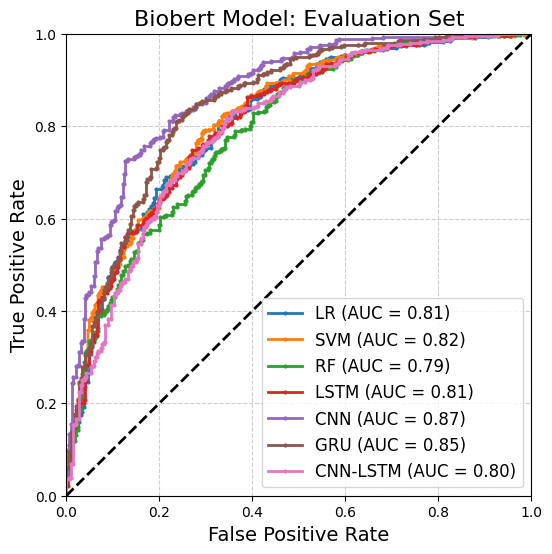

In [35]:
fpr, tpr, _ = roc_curve(unbias_labels, lr_pred_unbias[:,1])
fpr2, tpr2, _ = roc_curve(unbias_labels, svm_pred_unbias[:,1])
fpr3, tpr3, _ = roc_curve(unbias_labels, rf_pred_unbias[:,1])
fpr4, tpr4, _ = roc_curve(unbias_labels, lstm_pred_unbias)
fpr5, tpr5, _ = roc_curve(unbias_labels, cnn_pred_unbias)
fpr6, tpr6, _ = roc_curve(unbias_labels, gru_pred_unbias)
fpr7, tpr7, _ = roc_curve(unbias_labels, lc_pred_unbias)

# Calculate AUC 
roc_auc1 = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)

fprs = [fpr, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
tprs = [tpr, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
roc_aucs = [roc_auc1, roc_auc2, roc_auc3, roc_auc4, roc_auc5, roc_auc6, roc_auc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))  

for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, labels):
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc), marker='.', markersize=4)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Biobert Model: Evaluation Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/roc_curves_unbias.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
#AUPRC curves

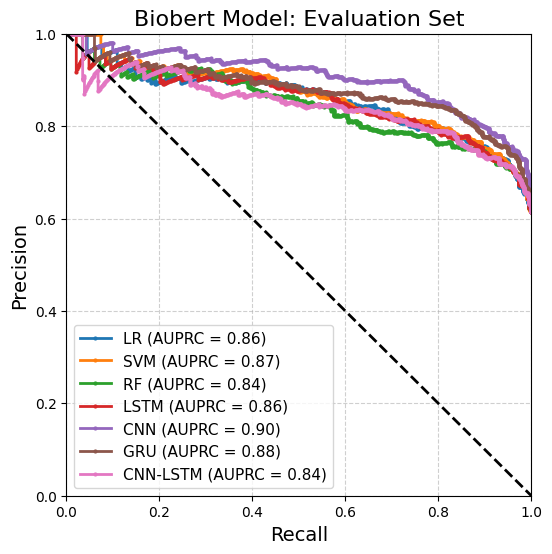

In [37]:
precision1, recall1, _ = precision_recall_curve(unbias_labels, lr_pred_unbias[:,1])
precision2, recall2, _ = precision_recall_curve(unbias_labels, svm_pred_unbias[:, 1])
precision3, recall3, _ = precision_recall_curve(unbias_labels, rf_pred_unbias[:, 1])
precision4, recall4, _ = precision_recall_curve(unbias_labels, lstm_pred_unbias)
precision5, recall5, _ = precision_recall_curve(unbias_labels, cnn_pred_unbias)
precision6, recall6, _ = precision_recall_curve(unbias_labels, gru_pred_unbias)
precision7, recall7, _ = precision_recall_curve(unbias_labels, lc_pred_unbias)

# Calculate AUPRC 
auprc1 = auc(recall1, precision1)
auprc2 = auc(recall2, precision2)
auprc3 = auc(recall3, precision3)
auprc4 = auc(recall4, precision4)
auprc5 = auc(recall5, precision5)
auprc6 = auc(recall6, precision6)
auprc7 = auc(recall7, precision7)

# Store the precision, recall, and AUPRC for each model
precisions = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
recalls = [recall1, recall2, recall3, recall4, recall5, recall6, recall7]
auprcs = [auprc1, auprc2, auprc3, auprc4, auprc5, auprc6, auprc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

# Plotting AUPRC curves
plt.figure(figsize=(6, 6))

for precision, recall, auprc, label in zip(precisions, recalls, auprcs, labels):
    plt.plot(recall, precision, lw=2, label='{} (AUPRC = {:.2f})'.format(label, auprc), marker='.', markersize=4)

plt.plot([0, 1], [1, 0], color='black', linestyle='--', lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Biobert Model: Evaluation Set', fontsize=16)

plt.legend(loc='lower left', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/prc_curves_unbias.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
# Calculate all metrics

In [39]:
dfs = []

algorithm_names = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']
predictions = [np.round(lr_pred_unbias[:,1]), np.round(svm_pred_unbias[:,1]), np.round(rf_pred_unbias[:,1])
               , np.round(lstm_pred_unbias), np.round(cnn_pred_unbias), np.round(gru_pred_unbias), np.round(lc_pred_unbias)]

# Iterate over each algorithm and calculate scores
for name, pred in zip(algorithm_names, predictions):
    conf_matrix = confusion_matrix(unbias_labels, pred)

    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 3)
    recall = round(recall, 3)
    specificity = round(specificity, 3)
    accuracy = round(accuracy, 3)
    f1 = round(f1, 3)

    # Create a DataFrame for each algorithm
    df = pd.DataFrame({
        'Algorithm': [name],
        'Precision': [precision],
        'Recall': [recall],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    })

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
scores_df = pd.concat(dfs, ignore_index=True)
scores_df.to_csv(models_path + '/scores_unbias.csv', index=False, sep='\t')

print(scores_df)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0        LR      0.762   0.883        0.562     0.759     0.818
1       SVM      0.759   0.892        0.550     0.760     0.820
2        RF      0.728   0.918        0.457     0.739     0.812
3      LSTM      0.725   0.928        0.441     0.739     0.814
4       CNN      0.797   0.904        0.634     0.800     0.847
5       GRU      0.763   0.922        0.547     0.777     0.835
6  CNN-LSTM      0.755   0.857        0.559     0.742     0.803


In [40]:
#Plot losses

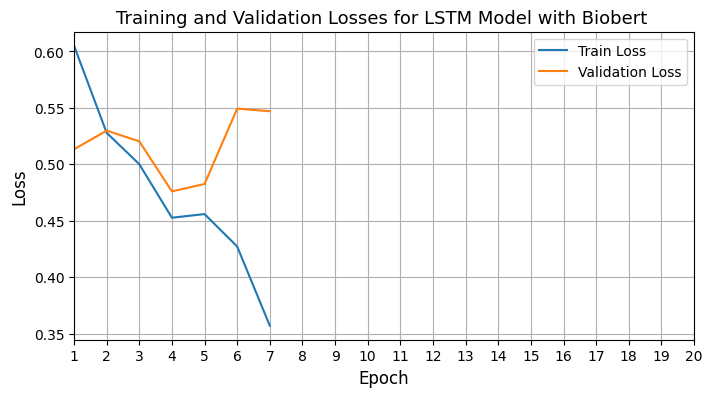

In [41]:
# Load the CSV file
df = pd.read_csv(models_path + "/best_fold_lstm_losses.csv")
# Plot the losses
plt.figure(figsize=(8, 4))

# Plot the training loss
plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

# Plot the validation loss
plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

# Set the x-axis limits
plt.xlim(1, 20)
plt.xticks(range(1, 21))  
plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for LSTM Model with Biobert ", size=13)
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(models_path + "/lstm_loss_plot.png", dpi=300)
plt.show()


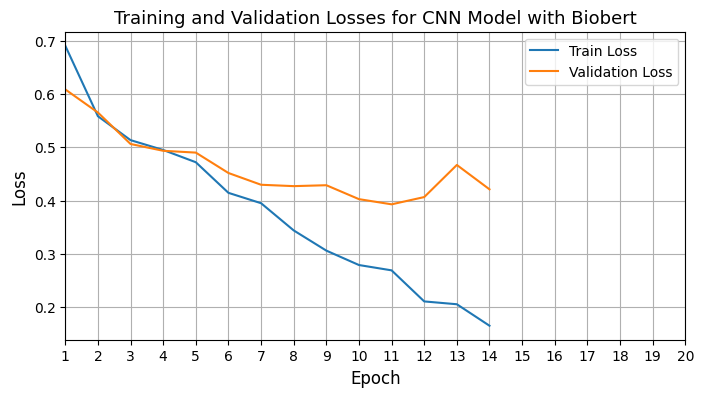

In [42]:
# Load the CSV file
df = pd.read_csv(models_path + "/best_fold_cnn_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 20)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for CNN Model with Biobert", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_loss_plot.png", dpi=300)
plt.show()


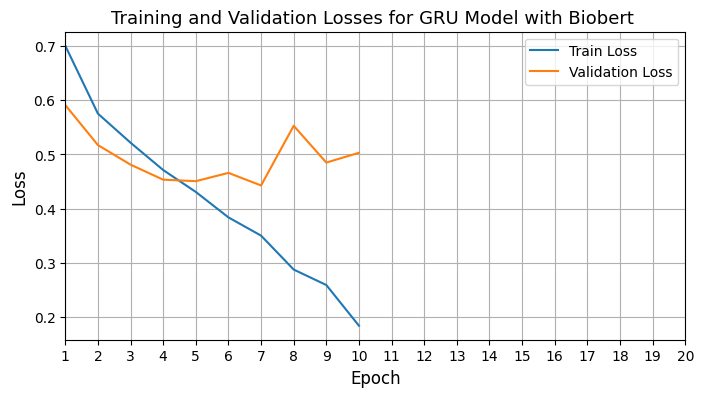

In [43]:
df = pd.read_csv(models_path + "/best_fold_gru_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 20)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for GRU Model with Biobert ", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/gru_loss_plot.png", dpi=300)

plt.show()

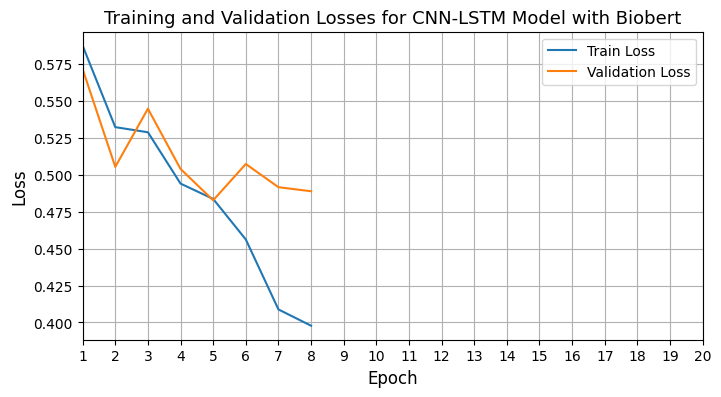

In [44]:
df = pd.read_csv(models_path + "/best_fold_cnn_lstm_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 10)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for CNN-LSTM Model with Biobert", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_lstm_loss_plot.png", dpi=300)

plt.show()